# Introduction au pricing d'options avec le modèle binomial

Dans ce notebook, nous allons explorer l'une des méthodes fondamentales d'évaluation des options financières : l'arbre binomial. L'arbre binomial est une méthode qui modélise les mouvements possibles du prix d'un actif sous-jacent au fil du temps pour évaluer une option. C'est une approche flexible et intuitive, qui peut être utilisée pour les options américaines et européennes, ainsi que pour les options plus complexes.

Notre objectif est de comprendre comment le prix de l'option est déterminé en fonction des différentes conditions du marché et des caractéristiques de l'option elle-même. Pour ce faire, nous allons définir et utiliser une fonction `binomial_tree_pricing` qui prend en compte plusieurs paramètres tels que le prix d'exercice de l'option (`K`), le prix initial de l'actif sous-jacent (`S0`), le taux d'intérêt sans risque (`r`), le rendement de l'actif (`q`), la volatilité de l'actif (`sigma`), la durée de l'option (`T`), le nombre de périodes dans l'arbre binomial (`N`), et le type d'option (`optype`). Nous intégrons également la possibilité de prendre en compte un dividende.

Nous utiliserons cette fonction pour évaluer une option put européenne dans un premier temps, puis nous examinerons comment le prix de l'option change lorsque nous modifions le nombre de périodes dans l'arbre binomial. 

Nous utiliserons le langage Python et plusieurs de ses bibliothèques populaires pour la manipulation de données et la visualisation, notamment pandas, numpy et matplotlib. 

Au fil de ce notebook, vous pourrez acquérir une meilleure compréhension de la méthode de l'arbre binomial et voir comment elle est mise en œuvre en pratique.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def binomial_tree_princing(K, S0, r, q, sigma, T, N, optype='P', dividende_date=0, dividende_actual=0):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp((r-q)*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    # initialise stock prices at maturity
    S = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
        
    # option payoff 
    if optype == 'P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        if i*dt <= dividende_date:
            S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
            S += dividende_actual
        else:
            S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
            
        C[:i+1] = disc * ( p*C[1:i+2] + (1-p)*C[0:i+1] )
        C = C[:-1]
        if i == 1:
            delta = (C[1]-C[0])/(S0*u-S0*d)
        if i == 2:
            gamma = (((C[2]-C[1])/(S0*u**2-S0))-((C[1]-C[0])/(S0-S0*d**2)))/(0.5*(S0*u**2-S0*d**2))
        if optype == 'P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)
    return C[0], delta, gamma



In [3]:
div = np.exp(-0.03*1.5/12)*2
price, delta, gamma = binomial_tree_princing(K=10, S0=10, r=0.06, q=0, sigma=0.5, T=1, N=20, optype='P')
print("Le prix de l'option est de {}".format(price))
print(30*"-")
print("Son Gamma est de {}".format(gamma))
print(30*"-")
print("Son Delta est de {}".format(delta)) 

Le prix de l'option est de 1.6917481005109407
------------------------------
Son Gamma est de 0.08488611848174252
------------------------------
Son Delta est de -0.37969600704079437


In [27]:
from math import log, sqrt, exp
from scipy.stats import norm

def BSM(S0, K, T, sigma, r, optype='P'):
    d1 = (log(S0/K) + (r + sigma**2/2))/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    
    if optype == 'P':
        price = K * exp(-r*T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    elif optype == 'C':
        price = S0 * norm.cdf(d1) - K * exp(-r*T) * norm.cdf(d2)
    else:
        raise ValueError("Invalid option type. Only 'P' (Put) and 'C' (Call) are supported.")
    
    return price

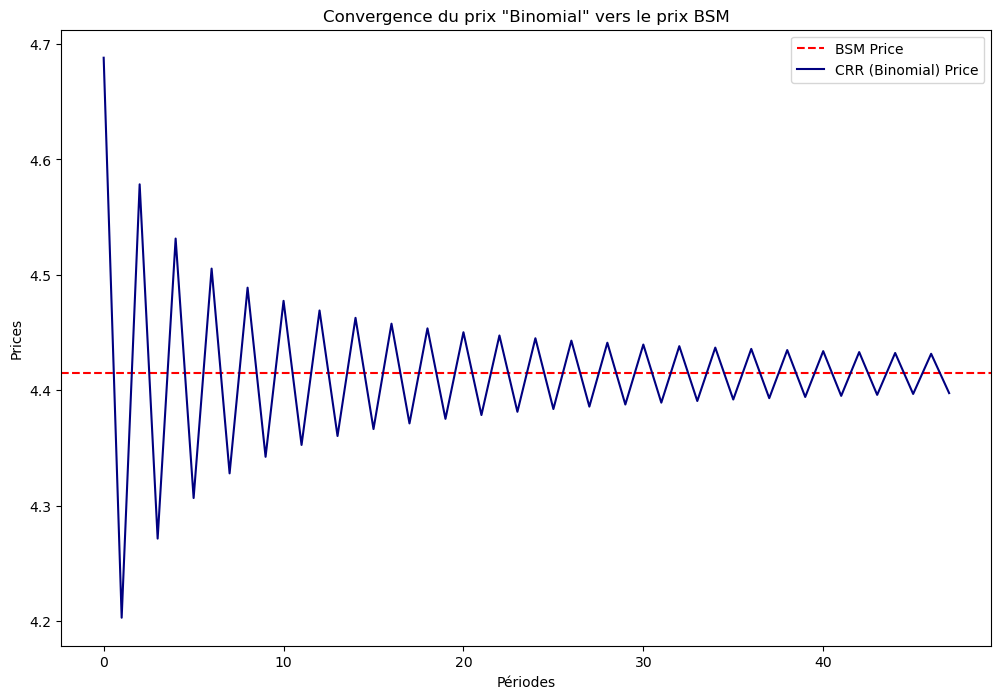

In [35]:
def plot_convergence(K, S0, r, sigma, T, N, optype='P'):
    x = np.array([])
    bsmprice = BSM(S0, K, T, sigma, r, optype)
    for i in range(3, N+1, 1):
        x = np.append(x, binomial_tree_princing(K=K, S0=S0, r=r, sigma=sigma, T=T, N=i, optype=optype, q=0)[0])
    plt.style.use('seaborn-v0_8-pastel')
    plt.figure(figsize=(12, 8))
    plt.axhline(y=bsmprice, linestyle='dashed', color='red', label='BSM Price')
    plt.plot(x, color='navy', label='CRR (Binomial) Price')
    plt.xlabel('Périodes')
    plt.ylabel('Prices')
    plt.title('Convergence du prix "Binomial" vers le prix BSM')
    plt.legend()

plot_convergence(30, 30, 0.06, 0.3, 1, 50, optype='C')
                

Dans la dernière partie de ce notebook, nous avons évalué le prix de l'option pour différents nombres de périodes dans l'arbre binomial et visualisé les résultats. Il est intéressant de constater qu'il semble y avoir une convergence du prix estimé vers une certaine valeur à mesure que le nombre de périodes augmente. Cette observation est en accord avec la théorie financière. 

En fait, lorsque l'on utilise un arbre binomial pour estimer le prix d'une option européenne sur une action qui ne verse pas de dividendes, la valeur du prix estimé devrait tendre vers la valeur obtenue en utilisant le modèle Black-Scholes-Merton (BSM) lorsque le nombre de périodes dans l'arbre tend vers l'infini. 

Formellement, nous pouvons exprimer cette affirmation comme suit :

Bien sûr, voici une présentation plus mathématique de la même idée :

Soit $ P_{N} $ le prix d'une option calculé en utilisant un arbre binomial avec $ N $ périodes, et $ P_{BSM}$ le prix de la même option calculé en utilisant le modèle Black-Scholes-Merton (BSM). Alors, si toutes les autres conditions restent constantes, nous avons :

$$ \lim_{{N \to \infty}} P_{N} = P_{BSM} $$ 

En d'autres termes, à mesure que le nombre de périodes \(N\) dans l'arbre binomial tend vers l'infini, le prix de l'option estimé en utilisant l'arbre binomial se rapproche de la valeur que nous obtiendrions en utilisant le modèle BSM.

# Continuation de l'Analyse du Modèle Binomial

Nous avons observé précédemment, à travers des expérimentations numériques, que le modèle binomial convergeait vers le modèle de Black-Scholes-Merton (BSM) lorsqu'on augmentait le nombre de périodes de l'arbre binomial. Cette convergence est particulièrement intéressante car elle établit un lien entre un modèle numérique intuitif et une formule analytique plus sophistiquée, validant ainsi la pertinence du modèle binomial tout en ouvrant la voie à une computation plus efficace via le modèle BSM.

Toutefois, la convergence observée expérimentalement mérite une explication plus formelle pour être pleinement acceptée. En effet, la finance quantitative, comme toute discipline basée sur des mathématiques rigoureuses, requiert que les observations numériques soient étayées par une démonstration mathématique solide.

Ainsi, dans cette continuation du notebook, nous allons nous pencher sur une démonstration mathématique de la convergence du modèle binomial vers le modèle BSM. Pour ce faire, nous revisiterons les formulations du modèle binomial et du modèle BSM, et nous montrerons, étape par étape, comment le modèle binomial se rapproche du modèle BSM à mesure que le nombre de périodes de l'arbre binomial augmente. Cet exercice va non seulement consolider notre compréhension des deux modèles, mais aussi approfondir notre connaissance de leurs interactions et similitudes intrinsèques.

## Dans le modèle de Black-Scholes-Merton, les variables sont les suivantes :

- $d_1$ : une variable représentant le premier terme du calcul de la valeur d'une option. Elle est définie par l'équation :
  $$ d_1 = \frac{\ln(S_0 / K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}} $$
  où :
  - $S_0$ est le prix actuel de l'actif sous-jacent (par exemple, une action).
  - $K$ est le prix d'exercice de l'option.
  - $r$ est le taux d'intérêt sans risque.
  - $\sigma$ est la volatilité du prix de l'actif sous-jacent.
  - $T$ est le temps restant jusqu'à l'échéance de l'option.

- $d_2$ : une variable représentant le deuxième terme du calcul de la valeur d'une option. Elle est définie par l'équation :
  $$ d_2 = \frac{\ln(S_0 / K) + (r - \sigma^2/2)T}{\sigma \sqrt{T}} $$
  où les variables ont la même signification que dans l'équation pour $d_1$.

- $c$ : la valeur d'un call option (option d'achat) dans le modèle de Black-Scholes-Merton. Elle est calculée par l'équation :
  $$ c = S_0 \Phi (d_1) - Ke^{-rT} \Phi (d_2) $$
  où les variables ont la même signification que dans les équations précédentes, et $\Phi$ représente la fonction de répartition de la distribution normale standard.

- $p$ : la valeur d'un put option (option de vente) dans le modèle de Black-Scholes-Merton. Elle est calculée par l'équation :
  $$ p = Ke^{-rT} \Phi (-d_2) - S_0 \Phi (-d_1) $$
  où les variables ont la même signification que dans les équations précédentes, et $\Phi$ représente la fonction de répartition de la distribution normale standard.

Ces variables sont utilisées pour évaluer le prix des options dans le modèle de Black-Scholes-Merton en fonction des paramètres du marché tels que le prix de l'actif sous-jacent, le prix d'exercice, la volatilité, le taux d'intérêt sans risque et le temps restant jusqu'à l'échéance.


## Dans le modèle binomial d'évaluation des options, les variables clés sont les suivantes :

- $u$ et $d$ : Ces deux variables représentent les facteurs par lesquels le prix de l'actif sous-jacent peut augmenter ou diminuer dans une période donnée. Ces facteurs sont définis par :
  $$ u = e^{\sigma \sqrt{\Delta t}}, d = e^{-\sigma \sqrt{\Delta t}} $$
  où :
  - $\sigma$ est la volatilité du prix de l'actif sous-jacent.
  - $\Delta t$ est la durée d'une période.
  
- $p$ : Cette variable représente la probabilité risque neutre que le prix de l'actif sous-jacent augmente. Elle est définie par :
  $$ p = \frac{e^{r\Delta t}-d}{u-d} $$
  où :
  - $r$ est le taux d'intérêt sans risque.
  - $u$ et $d$ sont les facteurs d'augmentation et de diminution de prix, définis précédemment.
  
- $C$ et $P$ : Ces variables représentent la valeur d'une option d'achat (call) et d'une option de vente (put) respectivement. Elles sont déterminées de manière récursive à partir de la formule :
  $$ C = e^{-r\Delta t}(pC_u + (1-p)C_d) $$
  
  $$ P = e^{-r\Delta t}(pP_u + (1-p)P_d) $$
  où :
  - $C_u$ et $C_d$ sont les valeurs de l'option d'achat si le prix de l'actif augmente ou diminue respectivement.
  - $P_u$ et $P_d$ sont les valeurs de l'option de vente si le prix de l'actif augmente ou diminue respectivement.
  - Les autres variables ont la même signification que dans les équations précédentes.

Ces variables sont utilisées pour évaluer le prix des options dans le modèle binomial en fonction des paramètres du marché tels que le prix de l'actif sous-jacent, le prix d'exercice, la volatilité, le taux d'intérêt sans risque et la durée de chaque période jusqu'à l'échéance.

Il est crucial de comprendre que les formules d'évaluation des options d'achat (call) et de vente (put) sont appliquées dans un processus de rétropropagation **si l'option peut et a un avantage d'être exercée avant échéance**.

Dans le contexte du modèle binomial, nous commençons par la fin de l'arbre binomial et examinons la valeur de l'option à l'échéance. Pour une option d'achat, cela serait $C = \max(S_T - K, 0)$ et pour une option de vente, $P = \max(K - S_T, 0)$, où $S_T$ est le prix de l'actif à la période $T$. Cela nous donne les valeurs finales de l'option pour chaque scénario de prix de l'actif sous-jacent à la fin de l'arbre binomial.

Une fois que nous avons les valeurs finales, nous remontons un cran à la période $T - \Delta t$. Ici, la valeur de l'option est calculée en utilisant les formules $C = e^{-r\Delta t}(pC_u + (1-p)C_d)$ pour une option d'achat et $P = e^{-r\Delta t}(pP_u + (1-p)P_d)$ pour une option de vente. Ces formules tiennent compte des valeurs de l'option si le prix de l'actif sous-jacent monte ($C_u$, $P_u$) ou descend ($C_d$, $P_d$) et des probabilités correspondantes, le tout actualisé au taux sans risque car nous sommes dans un univers risque neutre.

Nous répétons ce processus, remontant à chaque fois d'une période, jusqu'à atteindre le début de l'arbre à $T = 0$. C'est à ce nœud que nous obtenons la valeur de l'option au temps actuel. 

Ainsi, le modèle binomial utilise une approche dynamique et récursive pour estimer la valeur de l'option en se basant sur une multitude de scénarios possibles de mouvements de prix, et en actualisant ces valeurs potentielles à aujourd'hui à l'aide du taux d'intérêt sans risque.

Maintenant que nous possédons une meilleure compréhension des modèles, nous allons pouvoir démontrer le lien entre ces deux modèles.

Prenons un arbre à $n$ périodes pour évaluer une option européenne call sur une action ne versant pas de dividendes avec une volatilité du sous-jacent $\sigma$, une échéance $T$, un sous-jacent au prix $S_0$, les taux sans risque sont au taux $r$ et le strike est $K$. Si $j$ est le nombre de hausses, $i$ est le nombre de baisses et nous avons $i = n - j$, avec $u$ le coefficient de hausse et $d$ le coefficient de baisse. Le payoff de l'option doit être $\max(S_0u^jd^{n-j} - K, 0)$. Soit une loi binomiale où $j$ est le nombre de succès et $n$ le nombre d'essais, la probabilité d'avoir $j$ hausses est donc de 

$$ P(X = j) = \frac{n!}{(n-j)!j!}p^j(1-p)^{n-j} $$

On en déduit que l'espérance du payoff est 

$$ \sum_{j=0}^n \frac{n!}{(n-j)!j!}p^j(1-p)^{n-j} \max(S_0u^jd^{n-j} - K, 0) $$ 

Donc, le prix du call dans l'univers risque neutre est 

$$ C = e^{-rT}\sum_{j=0}^n \frac{n!}{(n-j)!j!}p^j(1-p)^{n-j} \max(S_0u^jd^{n-j} - K, 0) $$


Ici, la fonction $ \max $ nous empêche d'avancer. Or, nous savons que le payoff de l'option est toujours positif si $$ S_0u^i d^{n-j} > K $$ 
$$ j \ln(u) + (n-j) \ln(d) > \ln(K) - \ln(S_0) $$ 
$$ \ln(S_0/K) > -j\ln(u) - (n-j) \ln(d) $$ 

Nous savons aussi que $ u = e^{\sigma \sqrt{T/n}}$ et $d = e^{-\sigma \sqrt{T/n}}$, en remplaçant ces termes dans l'équation précédente, nous obtenons $$ \ln(S_0/K) > n \sigma \sqrt{T/n} - 2j\sigma\sqrt{T/n} $$

En isolant $ j $, nous obtenons $$ \alpha = j > \frac{n}{2} - \frac{\ln(S_0/K)}{2 \sigma\sqrt{T/n}} $$ 

Cela nous permet de résoudre le problème posé par la fonction $\max$, et nous obtenons :

$$ C = e^{-rT}\sum_{j>\alpha}^{n} \frac{n!}{(n-j)!j!}p^j(1-p)^{n-j} (S_0u^jd^{n-j} - K) $$

Il faut maintenant réorganiser tout cela pour rendre les choses plus claires, définissons deux variables $ U_1 $ et $ U_2 $ tel que 

$$ U_1 = \sum_{j>\alpha}^{n} \frac{n!}{(n-j)!j!}p^j(1-p)^{n-j}u^jd^{n-j} $$ 

$$ U_2 = \sum_{j>\alpha}^{n} \frac{n!}{(n-j)!j!}p^j(1-p)^{n-j} $$ 

$$ C = e^{-rT} (S_0U_1 - KU_2, 0) $$ 

$U_2$ est tout simplement la probabilité que le nombre de hausses $ j $ soit plus élevé que $ \alpha $ et si $j > \alpha$, alors le payoff est toujours positif.

Soit une loi binomiale $$ P(X=k) = C_n^k p^k (1-p)^{n-k} $$ et une loi normale $$ f(z) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(z-\mu)^2}{2\sigma^2}} $$ Une conséquence directe du **Théorème central limite** est que $$\frac{X - np}{\sqrt{np(1-p)}} \xrightarrow[n\to\infty]{\mathcal{L}} N(0,1)$$ 

Donc quand $ n\to\infty $, on peut en déduire que $$ U_2 = N\left(\frac{np - \alpha}{\sqrt{np(1-p)}}\right) $$ 
ainsi en remplaçant $ \alpha $ par sa valeur $$ U_2 = N\left(\frac{\ln\left(\frac{S_0}{K}\right)}{2\sigma\sqrt{T/n}\sqrt{p(1-p)}} + \frac{\sqrt{n}(p-\frac{1}{2})}{\sqrt{p(1-p)}}\right) $$ 

On peut calculer $ p $ grâce au modèle introduit plus haut, grâce à un calcul de limite, on en déduit la valeur des deux termes de l'équation ci-dessus qui utilise $ p $ 

$$ \lim_{{n \to \infty}} p(1-p) = \frac14 $$ et $$ \lim_{{n \to \infty}} \sqrt{n}(p-\frac12) = \frac{(r - \sigma^2/2)\sqrt{T}}{2\sigma} $$ 

On a juste à remplacer les termes dans $U_2$ et on obtient $$ U_2 = N\left(\frac{\ln(S_0/K) +(r - \sigma^2/2) T}{{\sigma\sqrt{T}}}\right) = N(d_2) $$ et on commence à voir apparaître notre modèle BSM !

Maintenant nous allons voir ce que l'on peut faire avec notre terme $U_1$ 

$$ U_1 = \sum_{j>\alpha}  \frac{n!}{(n-j)!j!} (pu)^j[(1-p)d]^{n-j} $$ 

Soit $$ q = \frac{pu}{pu +(1-p)d} $$, on en déduit facilement que: $$ 1-q = \frac{(1-p)d}{pu + (1-p)d} $$.

Avec cela, on peut écrire:

$$ U_1 = [pu + (1 - p)d]^n \sum_{j>\alpha}  \frac{n!}{(n-j)!j!} q^j (1-q)^{n-j} $$.

Grâce à l'astuce que l'on vient d'utiliser, on a pu arranger les termes de façon à avoir deux parties, une partie dont l'équation est celle de la loi binomiale avec une probabilité $q$ de succès et une autre partie où $ pu + (1 - p)d $ représente l'espérance de rentabilité entre deux périodes élevée à la puissance $n$. Or nous savons que nous valorisons les options dans un univers risque neutre, cela nous permet de remplacer $ pu + (1 - p)d $ par $ e^{r(T/n)} $ et grâce aux propriétés des fonctions exponentielles, on a finalement:

$$ U_1 = e^{rT} \sum_{j>\alpha} \frac{n!}{(n-j)!j!} q^j (1-q)^{n-j} $$.

Ensuite, on a juste à appliquer la même logique que pour $ U_2 $, c'est à dire que comme on prend $n \to \infty $ alors $\frac{X - nq}{\sqrt{nq(1-q)}} \xrightarrow[n\to\infty]{\mathcal{L}} N(0,1)$. Il va donc nous rester:

$$U_1 = e^{rT}N(\frac{nq - \alpha}{\sqrt{nq(1-q)}})$$.

Comme précédemment, on remplace alpha par sa valeur et on obtient :

$$ U_1 = e^{rT} N(\frac{\ln(S_0/K)}{2\sigma\sqrt{T}\sqrt{q(1-q)}} + \frac{\sqrt{n}(q-\frac12)}{\sqrt{q(1-q)}}) $$.

Nous connaissons la valeur de $p$, $$ p=\frac{e^{rT/n} - e^{-\sigma\sqrt{T/n}}}{e^{\sigma\sqrt{T/n}} - e^{-\sigma\sqrt{T/n}}} $$, ainsi que $ q $, $$ q = \frac{pu}{pu +(1-p)d} $$, on a plus qu'à substituer $u$, $d$ et $p$ dans $q$ puis développer pour obtenir:

$$ q = (\frac{e^{rT/n} - e^{-\sigma\sqrt{T/n}}}{e^{\sigma\sqrt{T/n}} - e^{-\sigma\sqrt{T/n}}}) ( \frac{e^{\sigma \sqrt{T/n}}}{e^{rT/n}}) $$.

Puis, même logique que plus haut, on calcule les limites des termes $ q(1-q) $ et de $ \sqrt{n} (q - \frac12)$ quand $n \to \infty $:

$$ \lim_{{n \to \infty}} q(1-q) = \frac14 $$ et $$ \lim_{{n \to \infty}} \sqrt{n}(q-\frac12) = \frac{(r + \sigma^2/2)\sqrt{T}}{2\sigma} $$.

On utilise ces résultats pour remplacer $ q(1-q) $ et $ \sqrt{n}(q-\frac12) $ dans $ U_1 $ et on finit par obtenir:

$$ U_1 = e^{rT} N(\frac{\ln(S_0 / K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}) = e^{rT} N(d_1) $$.

On rappelle que $ C = e^{-rT} (S_0U_1 - KU_2) $, donc on a juste à remplacer U_1 et U_2 par leurs expressions trouvées précédemment pour obtenir :

$$ C = S_0N(d_1) - Ke^{-rT}N(d_2) $$.

On retrouve bien la formule de pricing du call dans le modèle BSM !